# KGAT Inference & Explanation (Pure PyTorch) - With Names

這個 Notebook 展示如何載入訓練好的 KGAT 模型，並將路徑中的編號轉換為食譜名稱、成份與標籤。

In [1]:
import os
import sys
import torch
import argparse
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

if hasattr(torch.serialization, 'add_safe_globals'):
    torch.serialization.add_safe_globals([argparse.Namespace])

from src.model.kgat import KGAT
from src.model.explainer import KGATExplainer
from src.train import construct_adj, load_data

## 1. 載入資料與名稱映射

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if hasattr(torch, 'xpu') and torch.xpu.is_available(): device = torch.device('xpu')
print(f"Using device: {device}")

data_dir = '../data/processed'
interactions, kg_triples, stats = load_data(data_dir)

n_users, n_items, n_entities, n_relations = stats['n_users'], stats['n_items'], stats['n_entities'], stats['n_relations']

print("Loading recipe names...")
df_raw_recipes = pd.read_csv('../data/raw/RAW_recipes.csv')
recipe_id_to_name = dict(zip(df_raw_recipes['id'], df_raw_recipes['name']))

inv_ingredient_map = {v: k for k, v in stats['ingredient_map'].items()}
inv_tag_map = {v: k for k, v in stats['tag_map'].items()}
entity_id_to_name = {**inv_ingredient_map, **inv_tag_map}

def get_node_name(node_id):
    if node_id < n_users:
        original_user_id = stats['user_map'].inverse_transform([node_id])[0]
        return f"User({original_user_id})"
    elif node_id < n_users + n_items:
        remapped_item_id = node_id - n_users
        original_item_id = stats['item_map'].inverse_transform([remapped_item_id])[0]
        return recipe_id_to_name.get(original_item_id, f"Recipe({original_item_id})")
    else:
        remapped_entity_id = node_id - n_users - n_items
        return entity_id_to_name.get(remapped_entity_id, f"Entity({remapped_entity_id})")

adj = construct_adj(kg_triples, interactions, n_users, n_items, n_entities).to(device)

model_path = '../models/kgat_checkpoint_e20.pth'
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    embed_dim = getattr(checkpoint['args'], 'embed_dim', 64) if 'args' in checkpoint else 64
    model = KGAT(n_users, n_items + n_entities, n_relations, embed_dim=embed_dim).to(device)
    model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
    print("Model loaded successfully!")
else:
    print("Warning: Checkpoint not found.")
    model = KGAT(n_users, n_items + n_entities, n_relations).to(device)

model.eval()

Using device: xpu
Loading data from ../data/processed...
Loaded interactions.
Loaded kg_triples.
Loaded stats.
Loading recipe names...
Constructing Sparse Adjacency Matrix with Interactions...
Model loaded successfully!


KGAT(
  (user_embed): Embedding(226570, 64)
  (entity_embed): Embedding(247131, 64)
  (relation_embed): Embedding(2, 64)
  (aggregator_layers): ModuleList(
    (0): GNNLayer(
      (W1): Linear(in_features=64, out_features=64, bias=True)
      (W2): Linear(in_features=64, out_features=64, bias=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (1): GNNLayer(
      (W1): Linear(in_features=64, out_features=32, bias=True)
      (W2): Linear(in_features=64, out_features=32, bias=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
  )
)

## 2. 執行解釋與視覺化 (顯示名稱)

Target User: User(1535), Target Item: slow cooker chicken  tomato and white bean soup
Prediction Score: 0.8481

Top Explanation Paths (Gradient based):
 User(1535) -> slow cooker chicken  tomato and white bean soup (Score: 2.088745)
 User(1535) -> to die for crock pot roast -> User(1659272) -> slow cooker chicken  tomato and white bean soup (Score: 1.645986)
 User(1535) -> raspberry buttermilk muffins -> User(1617537) -> slow cooker chicken  tomato and white bean soup (Score: 1.535645)
 User(1535) -> outback steakhouse style steak -> User(2000431901) -> slow cooker chicken  tomato and white bean soup (Score: 1.224597)
 User(1535) -> easy stove top macaroni   cheese -> User(2000431901) -> slow cooker chicken  tomato and white bean soup (Score: 1.224578)


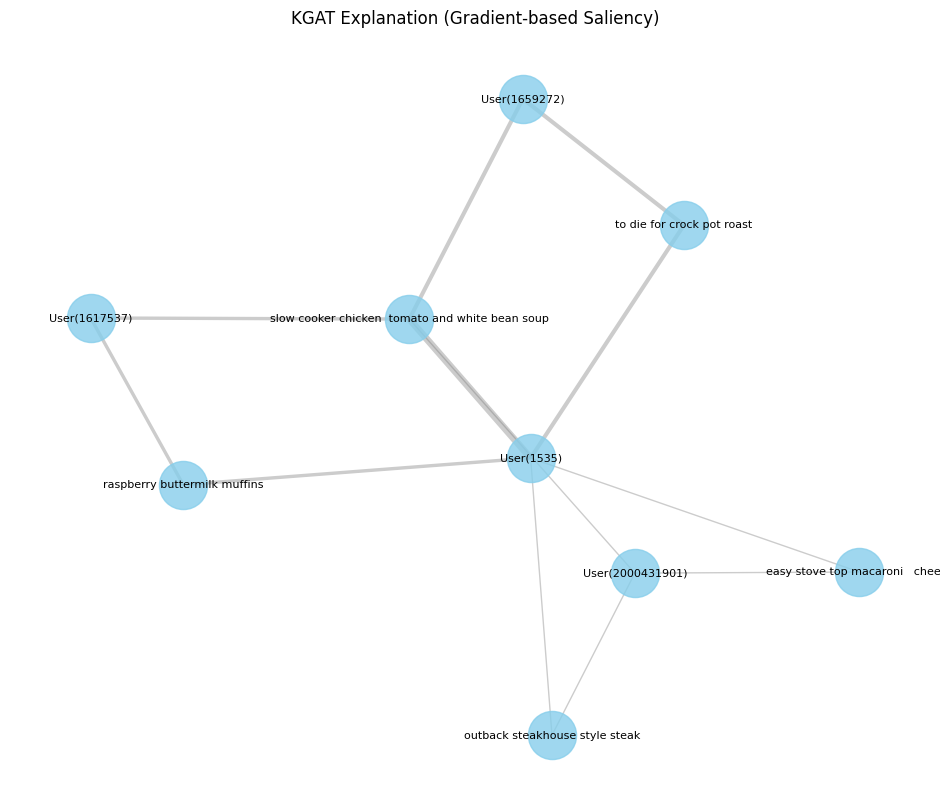

In [5]:
target_user = 1
user_interactions = interactions[interactions[:, 0] == target_user]

if len(user_interactions) > 0:
    target_item = int(user_interactions[0][1])
    print(f"Target User: {get_node_name(target_user)}, Target Item: {get_node_name(n_users + target_item)}")
    
    explainer = KGATExplainer(model)
    explanation = explainer.explain(adj, target_user, target_item, top_k=5, n_hops=2)
    
    if explanation:
        print(f"Prediction Score: {explanation['target_score']:.4f}")
        print("\nTop Explanation Paths (Gradient based):")
        for path, score in explanation['top_paths']:
            path_names = [get_node_name(node_id) for node_id in path]
            print(f" {' -> '.join(path_names)} (Score: {score:.6f})")
            
        graph = explanation['subgraph']
        labels = {node: get_node_name(node) for node in graph.nodes()}
        
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(graph)
        nx.draw_networkx_nodes(graph, pos, node_size=1200, node_color="skyblue", alpha=0.8)
        nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)
        
        weights = [graph[u][v]['weight'] for u, v in graph.edges()]
        if weights:
            max_w, min_w = max(weights), min(weights)
            widths = [(w - min_w)/(max_w - min_w + 1e-9) * 4 + 1 for w in weights]
            nx.draw_networkx_edges(graph, pos, width=widths, edge_color="gray", alpha=0.4)
            
        plt.title("KGAT Explanation (Gradient-based Saliency)")
        plt.axis('off')
        plt.show()
else:
    print(f"User {target_user} has no interactions.")